# Dashboard
* This notebook contains visualiations that could be incorporated into the final dashboard

In [1]:
import ast
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import regex as re
import seaborn as sns

from scipy.stats import chi2_contingency

In [2]:
df = pd.read_csv("parsed1.csv", index_col = 0)
df.drop(columns = ['docket_no'], inplace = True)

In [3]:
# convert string to datetime
#df["offense_date"] = pd.to_datetime(df["offense_date"])
df["arrest_dt"] = pd.to_datetime(df["arrest_dt"])
df["dob"] = pd.to_datetime(df["dob"])
df["bail_date"] = pd.to_datetime(df["bail_date"])
df["prelim_hearing_dt"] = pd.to_datetime(df["prelim_hearing_dt"])

# age column
df['age'] = df['dob'].apply(lambda x: 2020-x.year)

# public defender column: 1 if public defender, 0 if private defender
df["public_defender"] = df["attorney"].apply(lambda x: 1 if x =='Defender Association of  Philadelphia' else 0)

# convert type of "offenses" and "parsed_offenses" from string representation of list to list
df["offenses"] = df["offenses"].apply(lambda x: ast.literal_eval(x))
df["parsed_offenses"] = df["parsed_offenses"].apply(lambda x: ast.literal_eval(x))

# zipcode: remove everything after hyphen
df["zipcode_clean"] = df["zip"].apply(lambda x: re.sub('-.*$','',x) if type(x) == str else x)

# Create column indicating whether zipcode is in philadelphia or not
philly_zipcode = list(range(19102, 19155))
philly_zipcode = [str(item) for item in philly_zipcode]
df['philly_zipcode'] = df['zipcode_clean'].apply(lambda x: 1 if x in philly_zipcode else 0)

In [4]:
df.head()

,offenses,offense_date,arrest_dt,case_status,arresting_officer,attorney,dob,zip,bail_set_by,bail_amount,bail_paid,bail_date,bail_type,prelim_hearing_dt,prelim_hearing_time,parsed_offenses,age,public_defender,zipcode_clean,philly_zipcode
0,"[Rape Forcible Compulsion, Rape Forcible Compu...",5/28/20,2020-07-27,Active,"Bengochea, William",Defender Association of Philadelphia,1993-05-19,19123,"Bernard, Francis X.",300000,0,2020-07-28,Monetary,2020-07-28,4:49 AM,"[False Imprisonment, Indec Asslt-W/O Cons Of O...",27.0,1,19123,1
1,[Aggravated Assault - Attempts to cause SBI or...,5/4/20,2020-05-04,Active,"Soares, Baldomiro J. Jr.",Defender Association of Philadelphia,1997-05-05,19121,E-Filing Judge,50000,5000,2020-05-05,Monetary,2020-05-04,5:33 PM,[Aggravated Assault - Attempts to cause SBI or...,23.0,1,19121,1
2,"[Simple Assault, Simple Assault, Recklessly En...",2/2/20,2020-02-12,Active,"Jones, James",Defender Association of Philadelphia,1986-11-15,19124,"Stack, Patrick",7500,750,2020-02-13,Monetary,2020-02-13,8:22 AM,"[Recklessly Endangering Another Person, Simple...",34.0,1,19124,1
3,"[Contraband/Controlled Substance, Contraband/C...",2/10/20,2020-02-21,Active,"Balmer, James M.",Defender Association of Philadelphia,1980-12-13,19135,"Bernard, Francis X.",5000,0,2020-02-21,Unsecured,2020-02-21,8:34 PM,"[Contraband/Controlled Substance, Int Poss Con...",40.0,1,19135,1
4,"[Manufacture, Delivery, or Possession With Int...",3/13/20,2020-03-14,Active,"Sima, Raymond",Richard T. Brown Jr.,1997-11-05,19144,"Stack, Patrick",0,0,2020-03-14,ROR,2020-03-14,8:40 AM,"[Conspiracy, Int Poss Contr Subst By Per Not R...",23.0,0,19144,1


## 1. Aggregate bail information for the year 2020

## 2. Visualizations on magistrate information

In [45]:
print('Total number of magistrates: ', len(df['bail_set_by'].value_counts()))

Total number of magistrates:  88


<b> Total number of cases handled by each magistrate </b>

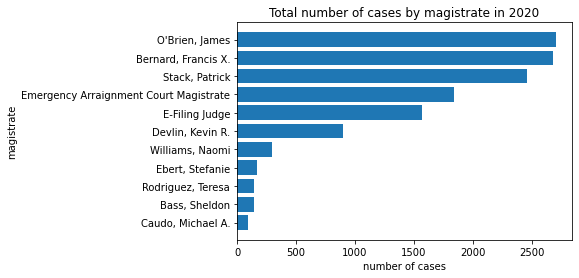

In [48]:
n_magistrates = 11
plt.barh(df['bail_set_by'].value_counts()[:n_magistrates].keys()[::-1], df['bail_set_by'].value_counts()[:n_magistrates].values[::-1])
plt.xlabel('number of cases')
plt.ylabel('magistrate')
plt.title('Total number of cases by magistrate in 2020')
plt.show()

<b> Bail type by magistrate </b>

In [132]:
df_magistrate = pd.crosstab(index = df['bail_set_by'], columns =df['bail_type'])
# note: total here excludes any entries with 'bail_type' == NaN
df_magistrate['Total'] = df_magistrate.sum(axis = 1)
df_magistrate.sort_values(by = ['Total'], ascending = False, inplace = True)
df_magistrate.head(11)

bail_type,Monetary,Nominal,Nonmonetary,ROR,Unsecured,Total
bail_set_by,,,,,,
"O'Brien, James",1201,0,52,578,841,2672
"Bernard, Francis X.",1230,0,46,541,804,2621
"Stack, Patrick",1007,1,2,1008,409,2427
Emergency Arraignment Court Magistrate,641,0,45,746,384,1816
E-Filing Judge,490,0,1,397,662,1550
"Devlin, Kevin R.",389,0,9,348,135,881
"Williams, Naomi",151,0,0,47,80,278
"Ebert, Stefanie",78,0,0,51,38,167
"Bass, Sheldon",42,0,0,60,43,145


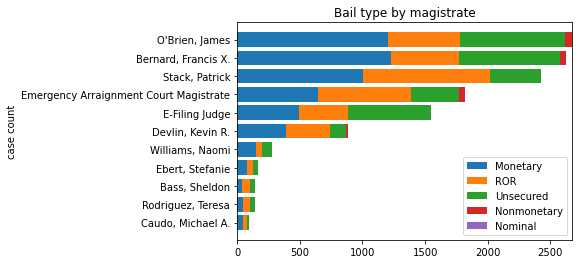

In [133]:
n_magistrates = 11

monetary = df_magistrate['Monetary'][:n_magistrates].values[::-1]
ROR = df_magistrate['ROR'][:n_magistrates].values[::-1]
Unsecured = df_magistrate['Unsecured'][:n_magistrates].values[::-1]
Nonmonetary = df_magistrate['Nonmonetary'][:n_magistrates].values[::-1]
Nominal = df_magistrate['Nominal'][:n_magistrates].values[::-1]
ind = range(n_magistrates)

plt.barh(ind, monetary)
plt.barh(ind, ROR, left = monetary)
plt.barh(ind, Unsecured, left = monetary + ROR)
plt.barh(ind, Nonmonetary, left = monetary + ROR + Unsecured)
plt.barh(ind, Nominal, left = monetary + ROR + Unsecured + Nonmonetary)
plt.legend(labels = ['Monetary', 'ROR', 'Unsecured', 'Nonmonetary', 'Nominal'])
plt.ylabel('magistrate')
plt.yticks(ind, df_magistrate.index[:n_magistrates][::-1])
plt.ylabel('case count')
plt.title('Bail type by magistrate')
plt.show()

In [ ]:
# since there are only a few nominal and non-monetary, combine them into 'other'
df_magistrate['Other'] = df_magistrate['Nominal'] + df_magistrate['Nonmonetary']

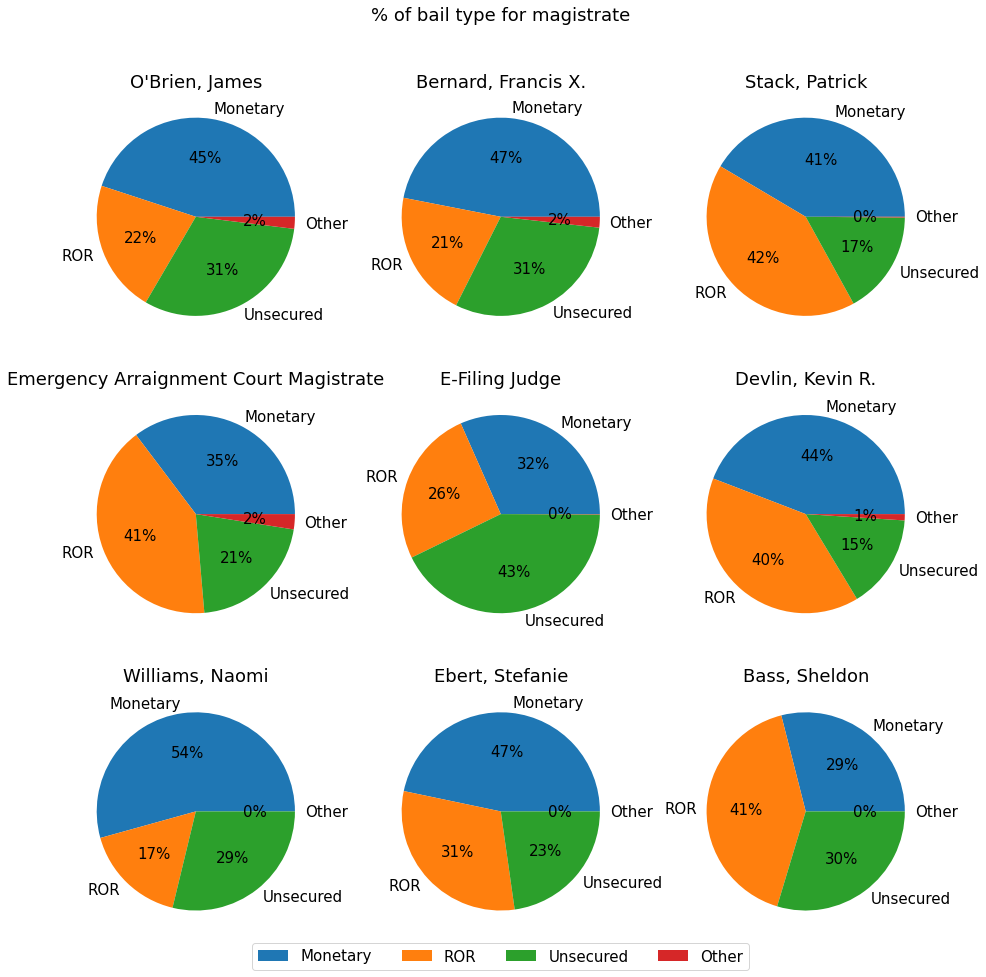

In [194]:
n_magistrates = 9
magistrates = df_magistrate.index[:n_magistrates]

bail_types = ['Monetary','ROR', 'Unsecured', 'Other']
fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize = (15, 15))
plt.rcParams['font.size'] = 15
fig.suptitle('% of bail type for magistrate')
for idx, name in enumerate(magistrates):
    row = idx // 3
    col = idx % 3 
    ax[row][col].pie(df_magistrate.loc[name, bail_types], labels = bail_types, autopct='%1.0f%%')
    ax[row][col].set_title(name)

# common legend
fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12)  # create some space below the plots by increasing the bottom-value
ax.flatten()[-2].legend(loc='upper center', bbox_to_anchor=(0.5, 0), ncol=4)

plt.show()

Q: Are bail type and magistrate related?  
* Take just the top 11 magistrates

In [135]:
n_magistrates = 11
# remove 'nominal' since we don't have enough cases 
df_chi = df_magistrate.drop(columns = ['Nominal', 'Nonmonetary', 'Total'])

# chi-squared test
chi2, p, dof, ex = chi2_contingency(df_chi[:n_magistrates])
print('p-value of chi-square test: ', p)

p-value of chi-square test:  2.8079464104504974e-160


* chi-square test tells us that **bail type and magistrate are related.**  

<b> For monetary bail, does bail amount vary by magistrate? </b>

In [130]:
# select magistrates to be the 11 magistrates with the highest number of cases
magistrates = df['bail_set_by'].value_counts().keys()[:11]

df['magistrate'] = df['bail_set_by'].apply(lambda x: 1 if x in magistrates else 0)
df_monetary = df[(df['bail_type'] == 'Monetary') & (df['magistrate'] == 1)][['bail_set_by', 'bail_amount']]

In [207]:
order = df_monetary.groupby(['bail_set_by']).bail_amount.median().sort_values(ascending = False).keys()

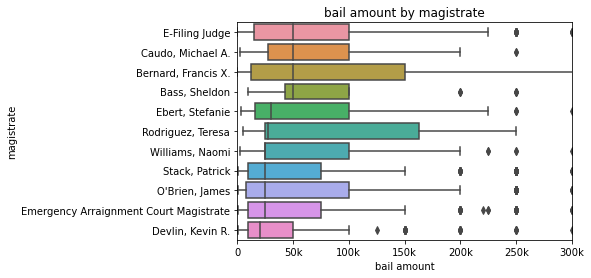

In [208]:
# Just switch x and y
plt.rcParams['font.size'] = 10
sns.boxplot( y=df_monetary["bail_set_by"], x=df["bail_amount"], 
           order = order)
plt.xlim(0, 300000)
plt.xlabel('bail amount')
plt.xticks(ticks = range(0, 350000, 50000), labels = ['0','50k','100k','150k','200k','250k','300k'])
plt.ylabel('magistrate')
plt.title('bail amount by magistrate')
plt.show()

In [ ]:
# change figure (order magistrates by median bail amount?)

In [ ]:
# t-test to compare mean  -- remove outliers before doing this 
# or look into Mann-Whitney U test

<b> Are specific magistrates more likely to handle specific types of offenses? </b>

## 3. Which neighborhoods are heavily impacted by bail?

The following visualizations shows that monetary bail largely impacts those who live in areas with severe poverty. 
* Left: Number of monetary bail cases by zip code. 
    * (We can regenerate the image for entire year of 2020 once we have the data) 
* Right: From US Census Bureau ASC 5-year estimate from 2018. 
    * data and link to table stored at 'data/poverty'.
    * Maybe we can grab 2020 data

data          |  visualization
:-------------------------:|:-------------------------:
Case count of monetary bail by zip code | <img src="visualizations/monetary_bail_case_count.png" alt="drawing" width="800"/>  |
Percentage of population living under poverty by zip code | <img src="visualizations/percent_below_poverty.png" alt="drawing" width="800"/> | 

The following visualizations show that the median household income is higher than median bail amount (\$25K) in many zip codes. 
* Left: median monetary bail amount by zip code.
    * Median computed only for zipcodes that had 6 or more cases.  
    * Median bail amount is usually \$25K
    * We can regenerate the image once we have 2020 data available. 
* Right: median household income by zipcode
    * From US Cenus Bureau 2018 ASC 5-year estimate from 2018. 
    * data and link to table stored at 'data/income' 
    * Maybe we can grab 2020 data


data          |  visualization
:-------------------------:|:-------------------------:
Median monetary bail amount by zip code            | <img src="visualizations/bail_amount.png" alt="drawing" width="800"/> |  
Median household income by zip code | <img src="visualizations/income.png" alt="drawing" width="800"/>


## 4. Break down by race and gender

## 5. How much Philadelphians paid in bail 